📂 Cargando datos históricos...
✅ Datos cargados: 755 días de trading para 5 activos.

📊 Retornos Esperados (Anualizados):
SPY    10.18%
GLD     6.82%
VNQ     4.41%
EEM    -0.93%
TLT    -7.09%
dtype: object

⚙️ Ejecutando optimización para Target = 8.0%

✨ OPTIMIZACIÓN EXITOSA
🛡️ Riesgo Mínimo (Volatilidad): 14.86%
📈 Retorno Esperado: 8.00%


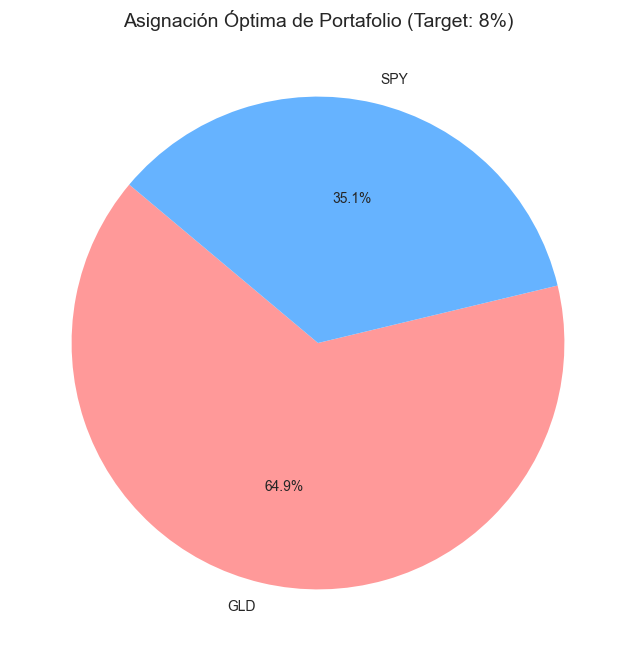


📋 ASIGNACIÓN DE ACTIVOS RECOMENDADA:
GLD    64.86%
SPY    35.14%
dtype: object


In [1]:
# -----------------------------------------------------------------------------
# M1: Optimización Convexa de Portafolios
# Notebook de Ejecución y Análisis
# -----------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# --- IMPORTACIÓN DE MÓDULOS PROPIOS (CLEAN CODE) ---
# Agregamos la ruta raíz del proyecto para poder importar desde 'src'
sys.path.append(os.path.abspath('..')) 

from src.data_loader import get_financial_metrics
from src.optimizer import optimize_portfolio

# Configuración visual (Estilo Yan Holtz)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# -----------------------------------------------------------------------------
# 1. CARGA DE DATOS REALES
# -----------------------------------------------------------------------------
print("📂 Cargando datos históricos...")
try:
    # Leemos los retornos generados en la Fase 2
    returns_df = pd.read_csv("../data/returns.csv", index_col=0, parse_dates=True)
    print(f"✅ Datos cargados: {returns_df.shape[0]} días de trading para {returns_df.shape[1]} activos.")
except FileNotFoundError:
    print("❌ Error: No se encuentra 'returns.csv'. Ejecuta primero 'src/data_loader.py'.")

# -----------------------------------------------------------------------------
# 2. CÁLCULO DE MÉTRICAS FINANCIERAS
# -----------------------------------------------------------------------------
mu, sigma = get_financial_metrics(returns_df)

print("\n📊 Retornos Esperados (Anualizados):")
print(mu.sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))

# -----------------------------------------------------------------------------
# 3. EJECUCIÓN DEL OPTIMIZADOR (EL CASO DE NEGOCIO)
# -----------------------------------------------------------------------------
# Definimos el escenario del cliente (Family Office)
TARGET_RETURN = 0.08  # Queremos un 8% anual (agresivo pero realista)

print(f"\n⚙️ Ejecutando optimización para Target = {TARGET_RETURN:.1%}")
result = optimize_portfolio(mu, sigma, TARGET_RETURN)

# -----------------------------------------------------------------------------
# 4. RESULTADOS Y VISUALIZACIÓN
# -----------------------------------------------------------------------------
if result['success']:
    print("\n✨ OPTIMIZACIÓN EXITOSA")
    print(f"🛡️ Riesgo Mínimo (Volatilidad): {result['risk']:.2%}")
    print(f"📈 Retorno Esperado: {result['return']:.2%}")
    
    # Preparamos datos para graficar
    weights = pd.Series(result['weights'], index=mu.index)
    weights = weights[weights > 0.0001] # Filtramos pesos irrelevantes (cero)
    
    # Gráfico de Torta (Allocation)
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=weights.index, autopct='%1.1f%%', 
            startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
    plt.title(f'Asignación Óptima de Portafolio (Target: {TARGET_RETURN:.0%})', fontsize=14)
    plt.show()
    
    # Mostrar tabla limpia
    print("\n📋 ASIGNACIÓN DE ACTIVOS RECOMENDADA:")
    print(weights.sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))
    
else:
    print(f"❌ La optimización falló: {result['message']}")
    print("Consejo: Intenta reducir el 'TARGET_RETURN'. Quizás el mercado no da para tanto.")


🔄 Calculando la Frontera Eficiente (esto puede tomar unos segundos)...


C:\Users\Eduar\AppData\Local\Temp\ipykernel_11360\250647527.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (asset_risks[i], mu[i]), xytext=(5,5), textcoords='offset points', fontsize=12)


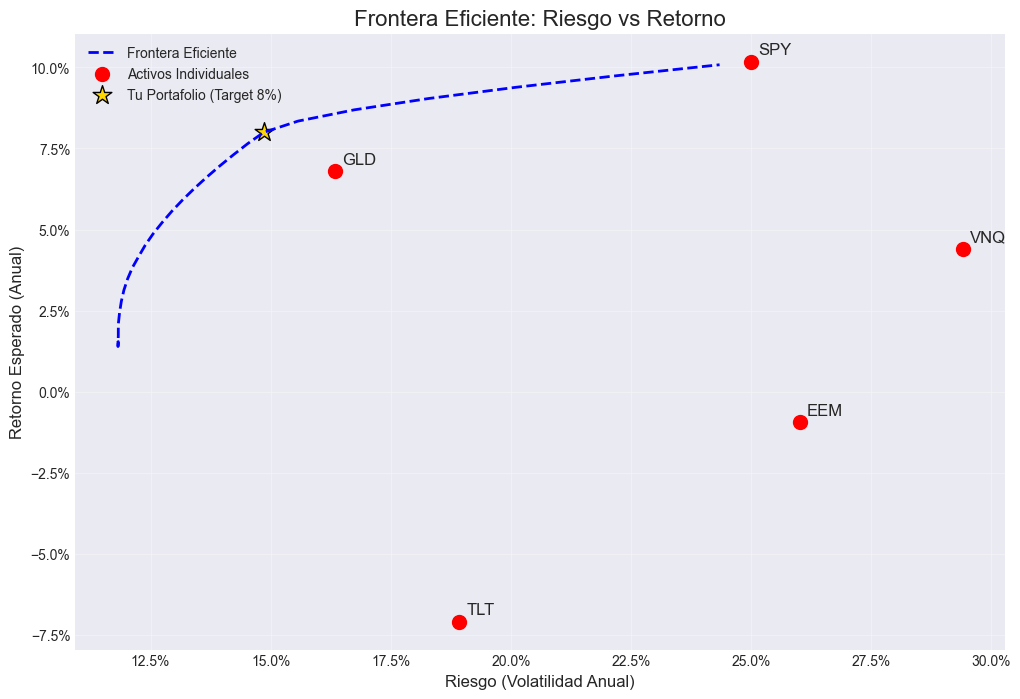

In [2]:
# -----------------------------------------------------------------------------
# 5. GENERACIÓN DE LA FRONTERA EFICIENTE
# -----------------------------------------------------------------------------
print("\n🔄 Calculando la Frontera Eficiente (esto puede tomar unos segundos)...")

# Definimos un rango de retornos objetivos (desde el min positivo hasta el max del SPY)
# Evitamos el negativo de TLT/EEM porque el solver no buscará perder dinero voluntariamente
min_ret = max(0, mu.min()) 
max_ret = mu.max() - 0.001 # Un pelín menos del máximo para evitar errores numéricos
target_returns = np.linspace(min_ret, max_ret, 30) # 30 escenarios diferentes

efficient_risks = []
efficient_returns = []

for target in target_returns:
    try:
        res = optimize_portfolio(mu, sigma, target)
        if res['success']:
            efficient_risks.append(res['risk'])
            efficient_returns.append(res['return'])
    except:
        pass

# -----------------------------------------------------------------------------
# 6. VISUALIZACIÓN FINAL
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 8))

# a) Curva de Frontera Eficiente
plt.plot(efficient_risks, efficient_returns, 'b--', linewidth=2, label='Frontera Eficiente')

# b) Activos Individuales (Puntos dispersos)
# Calculamos riesgo individual (diagonal de la covarianza)
asset_risks = np.sqrt(np.diag(sigma))
plt.scatter(asset_risks, mu, s=100, c='red', marker='o', label='Activos Individuales')

# Etiquetas para cada activo
for i, txt in enumerate(mu.index):
    plt.annotate(txt, (asset_risks[i], mu[i]), xytext=(5,5), textcoords='offset points', fontsize=12)

# c) Tu Portafolio Actual (El del 8%)
if result['success']:
    plt.scatter(result['risk'], result['return'], s=200, c='gold', marker='*', edgecolors='black', label=f'Tu Portafolio (Target {TARGET_RETURN:.0%})')

# Decoración
plt.title('Frontera Eficiente: Riesgo vs Retorno', fontsize=16)
plt.xlabel('Riesgo (Volatilidad Anual)', fontsize=12)
plt.ylabel('Retorno Esperado (Anual)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Formato de ejes a porcentajes
import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()